# Remaining user
Generates plots of the edit level changes of the users for different time periods.
Given a date, we generate users who were active both in the previous X days before the given date and after X days of the date. For all days we calculate the change in the edit numberts of the users

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_PATH = '/dlabdata1/turkish_wiki'

In [3]:
edits = pd.read_csv(f'{DATA_PATH}/processed_data/account_edits.csv', usecols=['event_user_id', 'event_timestamp', 'page_id'], index_col = 0)

In [6]:
edits = edits.reset_index()

In [7]:
edits['event_timestamp'] = pd.to_datetime(edits['event_timestamp'],   utc = True)

In [8]:
block_dates = [pd.to_datetime('2017-04-29', utc = True), pd.to_datetime('2020-01-15 19:00', utc = True)]
blocked_days = (block_dates[1] - block_dates[0]).days
edits = edits[edits['event_timestamp'] >= pd.to_datetime('2010-01-01', utc = True)]

In [11]:
edits['day'] = edits['event_timestamp'].dt.strftime("%Y-%m-%d")

In [16]:
daily_active_users = edits.groupby('day')['event_user_id'].apply(set)

In [24]:
daily_active_users = daily_active_users.reset_index().set_index('day')

In [29]:
def get_active_users(df, n_days):
    column_name = f"active_past_{n_days}_days"
    df[column_name] = [set.union(*daily_active_users.iloc[max(0, i-n_days-1): i+1, 0]) for i in range(len(daily_active_users.index))]
    return df

In [30]:
daily_active_users = get_active_users(daily_active_users, 30)
daily_active_users = get_active_users(daily_active_users, 90)
daily_active_users = get_active_users(daily_active_users, 600)

In [36]:
daily_active_users['active_next_30_days'] = daily_active_users['active_past_30_days'].shift(-30)
daily_active_users['active_next_90_days'] = daily_active_users['active_past_90_days'].shift(-90)
daily_active_users['active_next_600_days'] = daily_active_users['active_past_600_days'].shift(-600)

In [82]:
daily_active_users.loc[daily_active_users.active_next_30_days.isnull(), 'active_next_30_days'] = set()
daily_active_users.loc[daily_active_users.active_next_90_days.isnull(), 'active_next_90_days'] = set()
daily_active_users.loc[daily_active_users.active_next_600_days.isnull(), 'active_next_600_days'] = set()

In [85]:
daily_active_users['users_remaining_in_30_days'] = [a&b  for a, b  in zip(daily_active_users['active_next_30_days'], daily_active_users['active_past_30_days'])]
daily_active_users['users_remaining_in_90_days'] = [a&b  for a, b  in zip(daily_active_users['active_next_90_days'], daily_active_users['active_past_90_days'])]
daily_active_users['users_remaining_in_600_days'] = [a&b  for a, b  in zip(daily_active_users['active_next_600_days'], daily_active_users['active_past_600_days'])]

In [222]:
dates = pd.date_range(start='1/1/2010', end='2/01/2021', tz= 'utc')

In [358]:
edit_activities = pd.DataFrame(columns = ['30d_before', '30d_after', '90d_before', '90d_after', '200d_before', '200d_after', f'{blocked_days}d_before', f'{blocked_days}d_after'], index = dates)

In [365]:
def get_edit_changes(edits, dates, n_days):

    before_and_after_edits = np.zeros((dates.shape[0], 2))

    for idx, date in enumerate(dates):

        dateplus = date + pd.Timedelta(days=n_days)
        datemin =  date - pd.Timedelta(days=n_days)

        edits_before = edits[(edits['event_timestamp'] >= datemin) & (edits['event_timestamp'] <= date)]
        edits_after = edits[(edits['event_timestamp'] <= dateplus) & (edits['event_timestamp'] > date)]

#         usersmin = set(edits_before.event_user_id.unique())
#         usersmax = set(edits_after.event_user_id.unique())

#         users_remained = usersmin.intersection(usersmax)

        users_remained = set(edits_after.event_user_id.unique())


        nedits_before = edits_before[edits_before['event_user_id'].isin(users_remained)].shape[0]
        nedits_after = edits_after[edits_after['event_user_id'].isin(users_remained)].shape[0]

        before_and_after_edits[idx, 0] = nedits_before
        before_and_after_edits[idx, 1] = nedits_after
        
    return before_and_after_edits
    

In [366]:
edit_activities[['30d_before', '30d_after']] = get_edit_changes(edits, dates, 30)
edit_activities[['90d_before', '90d_after']] = get_edit_changes(edits, dates, 90)
edit_activities[['200d_before', '200d_after']] = get_edit_changes(edits, dates, 200)
edit_activities[[f'{blocked_days}d_before', f'{blocked_days}d_after']] = get_edit_changes(edits, dates, blocked_days)

In [369]:
edit_activities.iloc[range(0,30), 0] = 0
edit_activities.iloc[range(0,30), 1] = 0
edit_activities.iloc[range(0,90), 2] = 0
edit_activities.iloc[range(0,90), 3] = 0
edit_activities.iloc[range(0,200), 4] = 0
edit_activities.iloc[range(0,200), 5] = 0
edit_activities.iloc[:blocked_days, 6] = 0
edit_activities.iloc[:blocked_days, 7] = 0

In [370]:
edit_activities.iloc[-31:, 0] = 0
edit_activities.iloc[-31:, 1] = 0
edit_activities.iloc[-91:, 2] = 0
edit_activities.iloc[-91:, 3] = 0
edit_activities.iloc[-201:, 4] = 0
edit_activities.iloc[-201:, 5] = 0
edit_activities.iloc[-blocked_days-1:, 6] = 0
edit_activities.iloc[-blocked_days-1:, 7] = 0

In [371]:
for days in [30, 90, 200, blocked_days]:
    new_col = f"{days}d_pct_change"
    edit_activities[new_col] = (100*(edit_activities[f"{days}d_after"] - edit_activities[f"{days}d_before"])).div(edit_activities[f"{days}d_before"].where(edit_activities[f"{days}d_before"] != 0, np.nan))

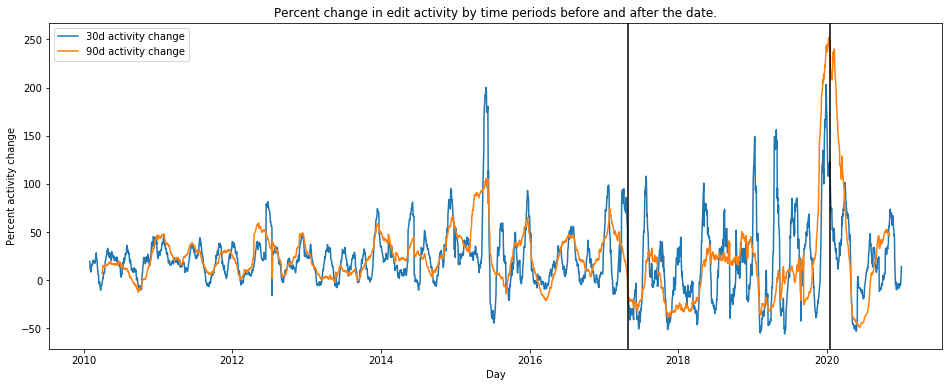

In [577]:
plt.figure(figsize=(16,6))
plt.title(f"Percent change in edit activity by time periods before and after the date.")

for days in [30, 90]:
    col = f"{days}d_pct_change"
    plt.plot(edit_activities.index.values, edit_activities[col], label = f"{days}d activity change")
    
for date in block_dates:
    plt.axvline(date, color = 'black')
    

plt.ylabel("Percent activity change")
plt.xlabel("Day")
plt.legend()
plt.show()

In [571]:
days = 30

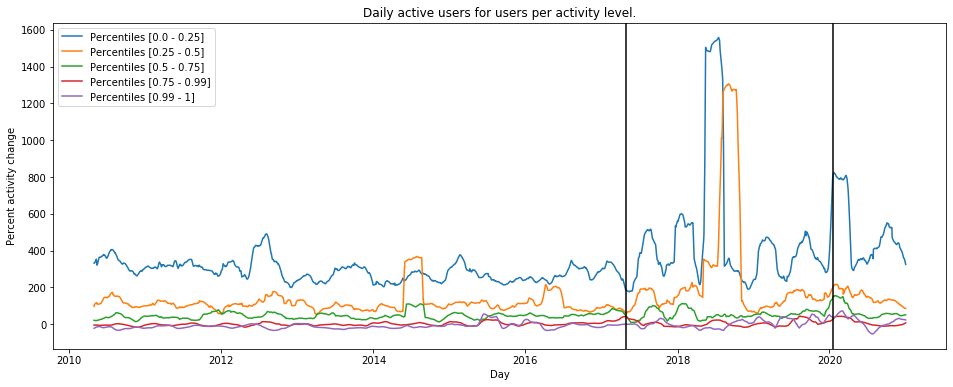

In [573]:
pctiles = ["[0.0 - 0.25]", "[0.25 - 0.5]", "[0.5 - 0.75]", "[0.75 - 0.99]", "[0.99 - 1]"]
plt.figure(figsize=(16,6))
plt.title(f"Daily active users for users per activity level.")
col = f"{days}d_pct_change"
for idx in range(5):
    category_users = edit_levels[edit_levels['percentile'] == idx]
    rolling_mean = category_users[col].rolling(window=90).mean()
    plt.plot(category_users.index.values, rolling_mean, label = f"Percentiles {pctiles[idx]}")
    
for date in block_dates:
    plt.axvline(date, color = 'black')

plt.ylabel("Percent activity change")
plt.xlabel("Day")
plt.legend()
plt.show()

In [356]:
edit_activities.to_csv(f'{DATA_PATH}/processed_data/edit_activities.csv')

In [429]:
def get_edit_changes_with_activity_levels(edits, dates, n_days):

    before_and_after_edits = np.zeros((dates[n_days:-n_days-1].shape[0], 5, 2))

    for idx, date in enumerate(dates[n_days:-n_days-1]):
        

        dateplus = date + pd.Timedelta(days=n_days)
        datemin =  date - pd.Timedelta(days=n_days)

        edits_before = edits[(edits['event_timestamp'] >= datemin) & (edits['event_timestamp'] <= date)]
        edits_after = edits[(edits['event_timestamp'] <= dateplus) & (edits['event_timestamp'] > date)]

#         usersmin = set(edits_before.event_user_id.unique())
#         usersmax = set(edits_after.event_user_id.unique())

#         users_remained = usersmin.intersection(usersmax)

        users_remained = set(edits_after.event_user_id.unique())


        edits_before = edits_before[edits_before['event_user_id'].isin(users_remained)].groupby('event_user_id').size().reset_index()
        edits_after = edits_after[edits_after['event_user_id'].isin(users_remained)].groupby('event_user_id').size().reset_index()
        
        edits_before.columns = ['event_user_id', 'nedits_before']
        edits_after.columns = ['event_user_id', 'nedits_after']

        
        summary_stats = edits_before.nedits_before.describe(percentiles=[0.25, 0.5, 0.75, 0.99])
        bins = [0] + list(summary_stats.values[4:9])
        
        edit_counts = pd.merge(edits_before, edits_after)
        edit_counts['edits_before_category'] = pd.cut(edit_counts.nedits_before, bins, right=True)
        
        edit_counts = edit_counts.groupby('edits_before_category')[['nedits_before', 'nedits_after']].sum()
        
        edit_counts.index = range(0,5)
               

        before_and_after_edits[idx] = edit_counts.values
        
    return before_and_after_edits.reshape(-1,2)
    

In [466]:
edit_levels = pd.DataFrame(columns = ['30d_before', '30d_after', '90d_before', '90d_after', '200d_before', '200d_after', f'{blocked_days}d_before', f'{blocked_days}d_after'], index = pd.MultiIndex.from_product([dates.to_list(), range(5)],
                           names=['date', 'percentile']))

In [511]:
for idx, num in enumerate([30, 90, 200, blocked_days]):
    
    low, high = idx*2, idx*2+2
    
    edit_levels.iloc[num*5:(-num-1)*5, low:high] = get_edit_changes_with_activity_levels(edits, dates, num)

ValueError: Must have equal len keys and value when setting with an iterable

In [550]:
edit_levels

30d_before 30d_after 90d_before  \
date                      percentile                                   
2010-01-01 00:00:00+00:00 0                 NaN       NaN        NaN   
                          1                 NaN       NaN        NaN   
                          2                 NaN       NaN        NaN   
                          3                 NaN       NaN        NaN   
                          4                 NaN       NaN        NaN   
...                                         ...       ...        ...   
2021-02-01 00:00:00+00:00 0                 NaN       NaN        NaN   
                          1                 NaN       NaN        NaN   
                          2                 NaN       NaN        NaN   
                          3                 NaN       NaN        NaN   
                          4                 NaN       NaN        NaN   

                                     90d_after 200d_before 200d_after  \
date                      percentile                                    
2010-01-01 00:00:00+00:00 0                NaN         NaN        NaN   
                          1                NaN         NaN        NaN   
                          2                NaN         NaN        NaN   
                          3                NaN         NaN        NaN   
                          4                NaN         NaN        NaN   
...                                        ...         ...        ...   
2021-02-01 00:00:00+00:00 0                NaN         NaN        NaN   
                          1                NaN         NaN        NaN   
                          2                NaN         NaN        NaN   
                          3                NaN         NaN        NaN   
                          4                NaN         NaN        NaN   

                                     991d_before 991d_after  
date                      percentile                         
2010-01-01 00:00:00+00:00 0                  NaN        NaN  
                          1                  NaN        NaN  
                          2                  NaN        NaN  
                          3                  NaN        NaN  
                          4                  NaN        NaN  
...                                          ...        ...  
2021-02-01 00:00:00+00:00 0                  NaN        NaN  
                          1                  NaN        NaN  
                          2                  NaN        NaN  
                          3                  NaN        NaN  
                          4                  NaN        NaN  

[20250 rows x 8 columns]

In [551]:
for days in [30, 90, 200, blocked_days]:
    new_col = f"{days}d_pct_change"
    edit_levels[new_col] = (100*(edit_levels[f"{days}d_after"] - edit_levels[f"{days}d_before"])).div(edit_levels[f"{days}d_before"].where(edit_levels[f"{days}d_before"] != 0, np.nan))


In [553]:
edit_levels[~edit_levels['30d_pct_change'].isna()]

30d_before 30d_after 90d_before  \
date                      percentile                                   
2010-01-31 00:00:00+00:00 0                 290      1287        NaN   
                          1                 482       832        NaN   
                          2                1599      2315        NaN   
                          3               24099     22527        NaN   
                          4               12965     12216        NaN   
...                                         ...       ...        ...   
2021-01-01 00:00:00+00:00 0                 385      1450        NaN   
                          1                 677      1245        NaN   
                          2                2785      4016        NaN   
                          3               38257     53851        NaN   
                          4               56449     35421        NaN   

                                     90d_after 200d_before 200d_after  \
date                      percentile                                    
2010-01-31 00:00:00+00:00 0                NaN         NaN        NaN   
                          1                NaN         NaN        NaN   
                          2                NaN         NaN        NaN   
                          3                NaN         NaN        NaN   
                          4                NaN         NaN        NaN   
...                                        ...         ...        ...   
2021-01-01 00:00:00+00:00 0                NaN         NaN        NaN   
                          1                NaN         NaN        NaN   
                          2                NaN         NaN        NaN   
                          3                NaN         NaN        NaN   
                          4                NaN         NaN        NaN   

                                     991d_before 991d_after 30d_pct_change  \
date                      percentile                                         
2010-01-31 00:00:00+00:00 0                  NaN        NaN        343.793   
                          1                  NaN        NaN        72.6141   
                          2                  NaN        NaN         44.778   
                          3                  NaN        NaN       -6.52309   
                          4                  NaN        NaN       -5.77709   
...                                          ...        ...            ...   
2021-01-01 00:00:00+00:00 0                  NaN        NaN        276.623   
                          1                  NaN        NaN        83.8996   
                          2                  NaN        NaN        44.2011   
                          3                  NaN        NaN        40.7612   
                          4                  NaN        NaN       -37.2513   

                                     90d_pct_change 200d_pct_change  \
date                      percentile                                  
2010-01-31 00:00:00+00:00 0                     NaN             NaN   
                          1                     NaN             NaN   
                          2                     NaN             NaN   
                          3                     NaN             NaN   
                          4                     NaN             NaN   
...                                             ...             ...   
2021-01-01 00:00:00+00:00 0                     NaN             NaN   
                          1                     NaN             NaN   
                          2                     NaN             NaN   
                          3                     NaN             NaN   
                          4                     NaN             NaN   

                                     991d_pct_change  
date                      percentile                  
2010-01-31 00:00:00+00:00 0                      NaN  
                          1                   

In [554]:
edit_levels.to_csv(f'{DATA_PATH}/processed_data/edit_levels.csv')

In [559]:
edit_levels = edit_levels.reset_index().set_index('date')